In [1]:
!pip install coca-pytorch
!pip install vit-pytorch>=0.35.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 367.7 kB/s eta 0:00:00a 0:00:01


In [79]:
import os
import json
import torch
import numpy as np
import transformers
import pandas as pd
import torch.nn as nn

from PIL import Image
from tqdm import tqdm
from vit_pytorch import ViT
from torch.optim import AdamW
from torchvision import transforms
from torch.nn import functional as F
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from transformers import BertTokenizer
from coca_pytorch.coca_pytorch import CoCa
from vit_pytorch.extractor import Extractor
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
path = '../input/48k-imdb-movies-data/Data'
image_ids, names, genres, descriptions = [], [], [], []
all_directories = os.listdir(path)
for directory in all_directories:
    directories = os.listdir(os.path.join(path, directory))
    for dir_ in directories:
        file_path = os.path.join(path, directory, dir_, dir_ + '.json')
        with open(file_path) as file:
            movie = json.load(file)
            try:
                description = movie['description']
                genre = movie['genre']
                descriptions.append(description)
                image_ids.append(dir_)
                names.append(movie['name'])
                genres.append(genre)
            except KeyError:
                continue

In [4]:
path = '../input/48k-imdb-movies-with-posters/Poster'
image_paths = []
all_directories = os.listdir(path)
for directory in all_directories:
    directories = os.listdir(os.path.join(path, directory))
    for dir_ in directories:
        file_path = os.path.join(path, directory, dir_, dir_ + '.jpg')
        image_paths.append(file_path)

In [5]:
image_paths = [path for path in image_paths if path != '../input/48k-imdb-movies-with-posters/Poster/2015/tt3317562/tt3317562.jpg']
image_paths = pd.Series(image_paths)

In [6]:
dict_ = dict(zip(image_paths.apply(lambda x: x.split('/')[5]), image_paths))

In [7]:
data = pd.DataFrame({'title': names,
                  'genres': genres,
                  'description': descriptions,
                  'image': image_ids})
data.image = data.image.map(dict_)
data.dropna(inplace=True)
data = data.sample(frac=1)
data.reset_index(drop=True, inplace=True)
data = data.explode('genres')
data = data.groupby(['title', 'description', 'image']).agg({'genres': lambda x: x.tolist()}).reset_index()

In [ ]:
mlb = MultiLabelBinarizer(sparse_output=True)
data = data.join(pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(data['genres']),
                index=data.index,
                columns=mlb.classes_))

In [17]:
targets = ['Action', 'Crime', 'Adventure', 'Thriller', 'Drama', 'Family',
           'Sport', 'Mystery', 'Western', 'History', 'Sci-Fi', 'Animation',
           'Documentary', 'Music', 'War', 'Biography', 'Musical', 'Superhero',
           'Horror', 'Short', 'Comedy', 'Fantasy', 'Romance', 'Film-Noir']

In [18]:
max_length = 512
input_size = 256
train_size = int(data.shape[0] * 0.7)
batch_size = 16

In [19]:
train_labels = data[targets].to_numpy()[:train_size]

In [20]:
def pad_and_truncate(input_ids, max_length):
    len_ids = len(input_ids)
    if len_ids < max_length:
        return np.pad(input_ids, (0, max_length - len_ids))
    return np.array(input_ids[:max_length])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', use_fast=True)

data['concat'] = data['title'] + ' | ' + data['description']
tokens = tokenizer(data['concat'].to_list())
input_ids = tokens['input_ids']

texts = np.array([pad_and_truncate(ids, max_length) for ids in input_ids])
texts = torch.from_numpy(texts)
texts_train = texts[:train_size]
texts_test = texts[train_size:]

In [22]:
def read_image(img_name, transform):
    image = Image.open(img_name)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return transform(image)

In [23]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

In [24]:
image_paths = data['image'].to_list()

images_train = image_paths[:train_size]
images_test = image_paths[train_size:]

In [25]:
vit = ViT(image_size=256,
          patch_size=32,
          num_classes=1000,
          dim=1024,
          depth=6,
          heads=16,
          mlp_dim=2048)

vit = Extractor(vit, return_embeddings_only=True, detach=False)

In [ ]:
coca = CoCa(dim=512,                       # model dimension
            img_encoder=vit,               # vision transformer - image encoder, returning image embeddings as (batch, seq, dim)
            image_dim=1024,                # image embedding dimension, if not the same as model dimensions
            num_tokens=tokenizer.vocab_size,  # number of text tokens
            unimodal_depth=6,              # depth of the unimodal transformer
            multimodal_depth=6,            # depth of the multimodal transformer
            dim_head=64,                   # dimension per attention head
            heads=8,                       # number of attention heads
            caption_loss_weight=1.,        # weight on the autoregressive caption loss
            contrastive_loss_weight=1.).cuda()  # weight on the contrastive loss between image and text CLS embeddings

In [23]:
n_steps = int(np.floor(len(texts_train) / batch_size))

for n_step in tqdm(range(n_steps), total=n_steps):
    start = n_step * batch_size
    end = (n_step + 1) * batch_size
    
    image_batch = images_train[start:end]
    image_batch = np.array([read_image(img_name,
                                       data_transforms['train']).numpy() for img_name in image_batch])
    image_batch = torch.tensor(image_batch).cuda()

    text_batch = texts_train[start:end].cuda()

    loss = coca(text=text_batch,
                images=image_batch,
                return_loss=True)

    loss.backward() 

100%|██████████| 2069/2069 [39:38<00:00,  1.15s/it]


###### 

In [24]:
for n_step in tqdm(range(n_steps), total=n_steps):
    start = n_step * batch_size
    end = (n_step + 1) * batch_size
    
    image_batch = images_train[start:end]
    image_batch = np.array([read_image(img_name,
                                       data_transforms['train']).numpy() for img_name in image_batch])
    image_batch = torch.tensor(image_batch).cuda()

    text_batch = texts_train[start:end].cuda()

    text_embeds, image_embeds = coca(text=text_batch,
                                         images=image_batch,
                                         return_embeddings=True)
    embed = text_embeds + image_embeds / 2
    
    np.savetxt(f'embed_{n_step}.out', embed.detach().cpu().numpy(), delimiter=',')

100%|██████████| 2069/2069 [07:13<00:00,  4.77it/s]


In [28]:
path = '/kaggle/working/'
a = os.listdir(path)
with ZipFile(os.path.join(path, 'sample3.zip'), 'w') as zipObj2:
    for filename in a:
        if filename.startswith('embed'):
            zipObj2.write(os.path.join(path, filename))
#             os.remove(os.path.join(path, filename))

In [29]:
from IPython.display import FileLink
FileLink(r'sample3.zip')

/kaggle/working/sample3.zip

In [238]:
class Classifier(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(Classifier, self).__init__()
        self.linear_1 = nn.Linear(input_dim, 64)
        self.leaky_relu_1 = nn.LeakyReLU(0.2)
        self.linear_2 = nn.Linear(64, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear_1(x)
        x = self.leaky_relu_1(x)
        x = self.linear_2(x)
        x = self.sigmoid(x)
        return x

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [348]:
classifier = Classifier(512, 24)
classifier.to(device)

Classifier(
  (linear_1): Linear(in_features=512, out_features=64, bias=True)
  (leaky_relu_1): LeakyReLU(negative_slope=0.2)
  (linear_2): Linear(in_features=64, out_features=24, bias=True)
  (sigmoid): Sigmoid()
)

In [42]:
path = '/kaggle/input/sample3/kaggle/working'
filenames = os.listdir(path)

In [48]:
embeddings = []
for filename in filenames:
    embeddings.append(np.loadtxt(os.path.join(path, filename), delimiter=','))

In [50]:
embeddings = np.asarray(embeddings)

In [255]:
learning_rate = 0.1
beta = 0.9
n_epochs = 1
n_steps = embeddings.shape[0]
training_steps = 1700
evaluation_steps = n_steps - training_steps

criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(classifier.parameters(), lr=learning_rate, betas=(beta, 0.999))

In [180]:
# labels_train = train_labels

In [256]:
for n_epoch in range(n_epochs):
    print('Epoch {}/{}'.format(n_epoch, n_epochs - 1))
    threshold = 0.3
    average_loss = 0.
    f1_scores = []
    phase = 'Train'
    for n_step in tqdm(range(training_steps), total=training_steps):
        classifier.train()
        start = n_step * batch_size
        end = (n_step + 1) * batch_size

        embed = torch.from_numpy(embeddings[n_step]).float() / 2

        labels = torch.from_numpy(labels_train[start:end]).float()
        
        classifier.zero_grad()
        
        output = classifier(embed)
        loss = criterion(output, labels)
        average_loss += loss
        f1_scores.append(f1_score(output > threshold, labels, average='micro'))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1.0)
        optimizer.step() 
    
    print('{} Loss: {:.4f} F1-score: {:.4f}'.format(phase, average_loss / training_steps, np.mean(f1_scores)))

    average_loss = 0.
    f1_scores = []
    phase = 'Evaluation'
    for n_step in tqdm(range(evaluation_steps), total=evaluation_steps):
        classifier.eval()
                
        with torch.no_grad():          
            start = (training_steps + n_step) * batch_size
            end = (training_steps + n_step + 1) * batch_size
            
            embed = torch.from_numpy(embeddings[n_step]).float() / 2
            labels = torch.from_numpy(labels_train[start:end]).float()
            
            output = classifier(embed)
            
            loss = criterion(output, labels)
        average_loss += loss
        f1_scores.append(f1_score(output > threshold, labels, average='micro'))
    
    print('{} Loss: {:.4f} F1-score: {:.4f}'.format(phase, average_loss / training_steps, np.mean(f1_scores)))

Epoch 0/0


100%|██████████| 1700/1700 [00:05<00:00, 316.07it/s]


Train Loss: 0.6975 F1-score: 0.3070


100%|██████████| 369/369 [00:00<00:00, 460.67it/s]

Evaluation Loss: 0.1514 F1-score: 0.2977


In [291]:
def get_pred(n_step):
    with torch.no_grad():  
        n = n_step * batch_size

        embed = torch.from_numpy(embeddings[n_step][0]).float() / 2
        labels = torch.from_numpy(labels_train[n]).float()

        output = classifier(embed)
    return output, labels

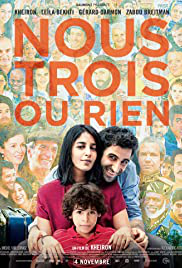

In [284]:
n_step = 1700
output, labels = get_pred(n_step)
Image.open(data.iloc[n_step * batch_size, 2])

In [285]:
with pd.option_context('display.max_colwidth', 500, 'display.max_columns', None):
    display(data.iloc[n_step * batch_size, :].to_frame().T[['title', 'description', 'genres']])

,title,description,genres
27200,Nous trois ou rien,"Nous trois ou rien is a movie starring Kheiron, Leïla Bekhti, and Gérard Darmon. An Iranian family survives the shah and the ayatollah and moves to France. This story follows the family through it all. Despite the politics,...","[Comedy, Drama]"


In [335]:
np.array(targets)[output > 0.3]

array(['Drama'], dtype='<U11')

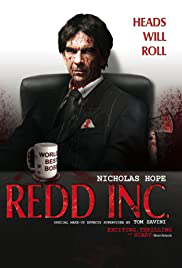

In [345]:
n_step = 1913
output, labels = get_pred(n_step)
Image.open(data.iloc[n_step * batch_size, 2])

In [346]:
with pd.option_context('display.max_colwidth', 500, 'display.max_columns', None):
    display(data.iloc[n_step * batch_size, :].to_frame().T[['title', 'description', 'genres']])

,title,description,genres
30608,Redd Inc.,"Redd Inc. is a movie starring Nicholas Hope, Kelly Paterniti, and Sam Reid. Six captive office workers are literally chained to their desks by deranged former regional manager Thomas Reddmann (Redd). He assigns his 'human resources'...","[Horror, Thriller]"


In [347]:
np.array(targets)[output > 0.5]

array(['Drama'], dtype='<U11')